## LSTM

1. choose a dataset
2. download and check the shape of the dataset
4. clean the data if needed (hint: regex)
5. decide the tokenization strategy (word , character , sub character)
6. build the vocab
7. build a wrapper around the dataset
8. dataloader -> train[0] (input,label)
9. Build network architecture
10. Training loop
11. evaluate


In [1]:
# -----------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
# For loading datasets
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Libraries imported successfully!


In [2]:
# Download the dataset
dataset = load_dataset("imdb")

# Get train and test data
train_data = dataset["train"]
test_data = dataset["test"]

# Display sample data
print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")


Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [3]:
def preprocess_text(text):
    """Clean and tokenize the text"""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

# Process training data
train_reviews = []
train_labels = []

for sample in tqdm(train_data):
    # Labels are already integers (0=negative, 1=positive)
    label_int = sample['label']
    train_labels.append(label_int)
    # Preprocess text
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

# Process test data
test_reviews = []
test_labels = []

for sample in tqdm(test_data):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)

print(f"Data preprocessing complete! Example tokenized review: {train_reviews[0][:15]}...")
print(f"Data preprocessing complete! Example tokenized label: {train_labels[0]}...")


100%|██████████| 25000/25000 [00:23<00:00, 1077.00it/s]

Data preprocessing complete! Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Data preprocessing complete! Example tokenized label: 0...


In [4]:
def build_vocab(reviews, max_words=10000):
    """Build a vocabulary of the most common words"""
    word_count = Counter()
    
    # Count all words
    for review in reviews:
        word_count.update(review)
    
    # Select most common words
    most_common = word_count.most_common(max_words - 2)  # -2 for <UNK> and <PAD>
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
    
    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    
    return vocab

# Build vocabulary from training data
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)

print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")

# Create a reverse mapping for decoding
idx_to_word = {idx: word for word, idx in vocab.items()}


Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


What should be the maximum length of my sequence aka review ??

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583.0


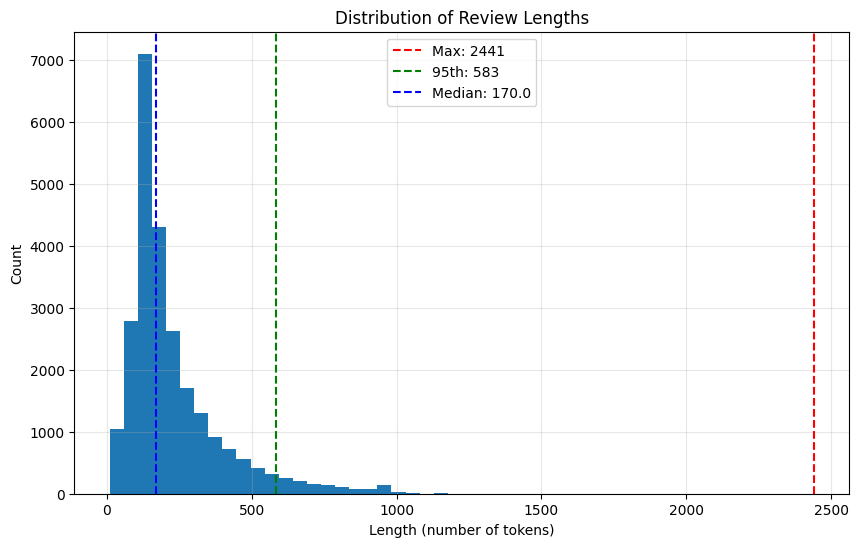

Chosen max_len: 583


100%|██████████| 25000/25000 [00:01<00:00, 16710.03it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 583
Reviews truncated: 1245 (4.98%)


In [5]:
# Analyze review lengths to determine optimal max_len
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Choose max_len based on 95th percentile to avoid excessive padding
# while still covering most reviews without truncation
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

def encode_review(review, vocab, max_len=None):
    """Convert a review to a fixed-length sequence of integers"""
    # Use the chosen max_len from analysis if none provided
    if max_len is None:
        max_len = chosen_max_len
        
    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]
    
    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    
    return encoded

# Encode all reviews using the dynamically determined max_len
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

# Calculate how many reviews were truncated
truncated_count = sum(1 for length in review_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(review_lengths)) * 100
print(f"Reviews truncated: {truncated_count} ({truncated_percentage:.2f}%)")


In [6]:
def encode_review(review, vocab, max_len=200):
    """Convert a review to a fixed-length sequence of integers"""
    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]
    
    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    
    return encoded

# Encode all reviews
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")


100%|██████████| 25000/25000 [00:00<00:00, 25066.89it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...


In [7]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create train/validation split
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

# Create datasets
train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}")


DataLoaders created! Training batches: 352


In [8]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                n_layers=1, bidirectional=False, dropout=0.5):
        super().__init__()
        
        # Architecture params
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        
        # Layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)
            
        # Calculate linear layer input dim
        linear_input_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(linear_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text))  # [batch, seq_len, emb_dim]
        
        # LSTM returns:
        # - lstm_out: all hidden states (unused here)
        # - (hidden, cell): tuple of final states
        _, (hidden, _) = self.lstm(embedded)
        
        # Handle bidirectional and multilayer
        if self.bidirectional:
            # Concatenate last forward & backward hidden states from last layer
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]  # Take last layer's hidden state
        
        return self.fc(self.dropout(hidden))

In [9]:

# Initialize model
embedding_dim = 100
hidden_dim = 256
output_dim = 1

In [10]:

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [11]:
models = {
    # Unidirectional models
    "1-Layer": SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,
                            n_layers=1, bidirectional=False, dropout=0).to(device),
    
    "2-Layer": SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,
                            n_layers=2, bidirectional=False).to(device),
    
    "3-Layer": SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,
                            n_layers=3, bidirectional=False).to(device),
    
    # Bidirectional models
    "1-Layer-Bi": SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,
                                n_layers=1, bidirectional=True, dropout=0).to(device),
    
    "2-Layer-Bi": SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,
                                n_layers=2, bidirectional=True).to(device),
    
    "3-Layer-Bi": SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,
                                n_layers=3, bidirectional=True).to(device)
}

In [12]:
def train(model, iterator, optimizer, criterion):
    """Training function for one epoch"""
    # Set model to training mode
    model.train()
    
    # Track loss
    epoch_loss = 0
    epoch_acc = 0
    
    # Iterate over batches
    for batch in tqdm(iterator, desc="Training"):
        # Get batch data
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text).squeeze(1)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Calculate accuracy
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float()
        accuracy = correct.sum() / len(correct)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
    
    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [13]:
def evaluate(model, iterator, criterion):
    """Evaluation function"""
    # Set model to evaluation mode
    model.eval()
    
    # Track loss
    epoch_loss = 0
    epoch_acc = 0
    
    # No gradients needed for evaluation
    with torch.no_grad():
        # Iterate over batches
        for batch in tqdm(iterator, desc="Evaluating"):
            # Get batch data
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            
            # Forward pass
            predictions = model(text).squeeze(1)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Calculate accuracy
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            accuracy = correct.sum() / len(correct)
            
            # Update metrics
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()
    
    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [14]:
n_epochs = 10
history = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name} Model")
    print(f"{'='*50}")

    # Lists to store metrics
    history[model_name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    best_val_acc = 0
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")
        print("-" * 20)
        
        # Train
        model.train()
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        history[model_name]['val_loss'].append(val_loss)
        history[model_name]['val_acc'].append(val_acc)
        
        
        # Print metrics
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name.replace("-", "_")}.pth')
            print(f"↻ New best model saved (val_acc: {val_acc*100:.2f}%)")
        

print("\nTraining complete!")


Training 1-Layer Model

Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 155.12it/s]


Train Loss: 0.6933 | Train Acc: 51.28%
Val Loss: 0.6962 | Val Acc: 51.80%
↻ New best model saved (val_acc: 51.80%)

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 151.86it/s]


Train Loss: 0.6884 | Train Acc: 52.48%
Val Loss: 0.6929 | Val Acc: 51.84%
↻ New best model saved (val_acc: 51.84%)

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Train Loss: 0.6757 | Train Acc: 56.36%
Val Loss: 0.6920 | Val Acc: 50.66%

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 165.22it/s]


Train Loss: 0.6790 | Train Acc: 55.64%
Val Loss: 0.6799 | Val Acc: 57.11%
↻ New best model saved (val_acc: 57.11%)

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 152.10it/s]


Train Loss: 0.6629 | Train Acc: 57.42%
Val Loss: 0.7314 | Val Acc: 50.23%

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 164.73it/s]


Train Loss: 0.6013 | Train Acc: 64.68%
Val Loss: 0.5245 | Val Acc: 73.40%
↻ New best model saved (val_acc: 73.40%)

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 153.00it/s]


Train Loss: 0.3706 | Train Acc: 84.14%
Val Loss: 0.4185 | Val Acc: 80.74%
↻ New best model saved (val_acc: 80.74%)

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 152.48it/s]


Train Loss: 0.2665 | Train Acc: 89.63%
Val Loss: 0.3950 | Val Acc: 83.95%
↻ New best model saved (val_acc: 83.95%)

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 155.46it/s]


Train Loss: 0.2003 | Train Acc: 92.68%
Val Loss: 0.4228 | Val Acc: 81.37%

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 165.71it/s]


Train Loss: 0.1490 | Train Acc: 94.79%
Val Loss: 0.4465 | Val Acc: 83.67%

Training 2-Layer Model

Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 80.51it/s]


Train Loss: 0.6938 | Train Acc: 50.43%
Val Loss: 0.6929 | Val Acc: 50.04%
↻ New best model saved (val_acc: 50.04%)

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 90.08it/s]


Train Loss: 0.6924 | Train Acc: 52.29%
Val Loss: 0.6924 | Val Acc: 49.73%

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 94.80it/s]


Train Loss: 0.6946 | Train Acc: 50.46%
Val Loss: 0.6936 | Val Acc: 48.71%

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.83it/s]


Train Loss: 0.6936 | Train Acc: 49.75%
Val Loss: 0.6931 | Val Acc: 51.29%
↻ New best model saved (val_acc: 51.29%)

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.67it/s]


Train Loss: 0.6934 | Train Acc: 49.17%
Val Loss: 0.6934 | Val Acc: 48.71%

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 87.49it/s]


Train Loss: 0.6932 | Train Acc: 50.32%
Val Loss: 0.6937 | Val Acc: 48.71%

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 86.87it/s]


Train Loss: 0.6933 | Train Acc: 50.08%
Val Loss: 0.6931 | Val Acc: 51.21%

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.92it/s]


Train Loss: 0.6937 | Train Acc: 50.12%
Val Loss: 0.6938 | Val Acc: 48.71%

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 85.97it/s]


Train Loss: 0.6934 | Train Acc: 50.73%
Val Loss: 0.6931 | Val Acc: 51.80%
↻ New best model saved (val_acc: 51.80%)

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 81.37it/s]


Train Loss: 0.6936 | Train Acc: 50.72%
Val Loss: 0.6917 | Val Acc: 53.09%
↻ New best model saved (val_acc: 53.09%)

Training 3-Layer Model

Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 60.97it/s]


Train Loss: 0.6937 | Train Acc: 50.85%
Val Loss: 0.6920 | Val Acc: 52.15%
↻ New best model saved (val_acc: 52.15%)

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 54.26it/s]


Train Loss: 0.6904 | Train Acc: 52.41%
Val Loss: 0.6893 | Val Acc: 52.23%
↻ New best model saved (val_acc: 52.23%)

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 60.97it/s]


Train Loss: 0.6952 | Train Acc: 51.52%
Val Loss: 0.6938 | Val Acc: 48.67%

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 56.97it/s]


Train Loss: 0.6933 | Train Acc: 50.58%
Val Loss: 0.6931 | Val Acc: 51.29%

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 56.12it/s]


Train Loss: 0.6935 | Train Acc: 50.51%
Val Loss: 0.6930 | Val Acc: 51.29%

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 64.72it/s]


Train Loss: 0.6937 | Train Acc: 49.41%
Val Loss: 0.6935 | Val Acc: 48.67%

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 61.00it/s]


Train Loss: 0.6932 | Train Acc: 49.86%
Val Loss: 0.6941 | Val Acc: 48.67%

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 60.80it/s]


Train Loss: 0.6932 | Train Acc: 49.93%
Val Loss: 0.6942 | Val Acc: 48.67%

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 64.06it/s]


Train Loss: 0.6933 | Train Acc: 49.82%
Val Loss: 0.6936 | Val Acc: 48.67%

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 65.28it/s]


Train Loss: 0.6932 | Train Acc: 50.07%
Val Loss: 0.6939 | Val Acc: 48.67%

Training 1-Layer-Bi Model

Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 81.61it/s]


Train Loss: 0.6524 | Train Acc: 61.47%
Val Loss: 0.5716 | Val Acc: 71.33%
↻ New best model saved (val_acc: 71.33%)

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 95.85it/s] 


Train Loss: 0.5983 | Train Acc: 68.39%
Val Loss: 0.5654 | Val Acc: 71.76%
↻ New best model saved (val_acc: 71.76%)

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 93.97it/s]


Train Loss: 0.4941 | Train Acc: 77.02%
Val Loss: 0.5086 | Val Acc: 76.64%
↻ New best model saved (val_acc: 76.64%)

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 89.55it/s]


Train Loss: 0.4559 | Train Acc: 78.77%
Val Loss: 0.4890 | Val Acc: 76.72%
↻ New best model saved (val_acc: 76.72%)

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 89.61it/s]


Train Loss: 0.3564 | Train Acc: 84.70%
Val Loss: 0.3919 | Val Acc: 82.93%
↻ New best model saved (val_acc: 82.93%)

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 93.36it/s]


Train Loss: 0.2823 | Train Acc: 88.30%
Val Loss: 0.3712 | Val Acc: 84.80%
↻ New best model saved (val_acc: 84.80%)

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 91.98it/s]


Train Loss: 0.2210 | Train Acc: 91.44%
Val Loss: 0.3937 | Val Acc: 84.65%

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 91.81it/s]


Train Loss: 0.1666 | Train Acc: 93.66%
Val Loss: 0.4579 | Val Acc: 84.10%

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 90.65it/s]


Train Loss: 0.1113 | Train Acc: 95.97%
Val Loss: 0.4663 | Val Acc: 84.14%

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 91.30it/s]


Train Loss: 0.0657 | Train Acc: 97.80%
Val Loss: 0.5913 | Val Acc: 83.44%

Training 2-Layer-Bi Model

Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 44.13it/s]


Train Loss: 0.6825 | Train Acc: 55.57%
Val Loss: 0.6949 | Val Acc: 51.17%
↻ New best model saved (val_acc: 51.17%)

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 44.56it/s]


Train Loss: 0.6923 | Train Acc: 51.70%
Val Loss: 0.6931 | Val Acc: 50.35%

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 44.64it/s]


Train Loss: 0.6911 | Train Acc: 52.69%
Val Loss: 0.6812 | Val Acc: 55.78%
↻ New best model saved (val_acc: 55.78%)

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 48.86it/s]


Train Loss: 0.6789 | Train Acc: 56.72%
Val Loss: 0.6450 | Val Acc: 61.41%
↻ New best model saved (val_acc: 61.41%)

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 47.43it/s]


Train Loss: 0.6208 | Train Acc: 65.01%
Val Loss: 0.6586 | Val Acc: 55.98%

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 45.87it/s]


Train Loss: 0.6657 | Train Acc: 59.56%
Val Loss: 0.6444 | Val Acc: 61.76%
↻ New best model saved (val_acc: 61.76%)

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 46.46it/s]


Train Loss: 0.6477 | Train Acc: 61.98%
Val Loss: 0.6687 | Val Acc: 60.16%

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 44.68it/s]


Train Loss: 0.6005 | Train Acc: 68.47%
Val Loss: 0.5665 | Val Acc: 72.89%
↻ New best model saved (val_acc: 72.89%)

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 45.84it/s]


Train Loss: 0.4759 | Train Acc: 77.95%
Val Loss: 0.4237 | Val Acc: 80.62%
↻ New best model saved (val_acc: 80.62%)

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Train Loss: 0.4095 | Train Acc: 82.07%
Val Loss: 0.3791 | Val Acc: 83.98%
↻ New best model saved (val_acc: 83.98%)

Training 3-Layer-Bi Model

Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 28.88it/s]


Train Loss: 0.6901 | Train Acc: 52.92%
Val Loss: 0.6909 | Val Acc: 50.23%
↻ New best model saved (val_acc: 50.23%)

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 28.63it/s]


Train Loss: 0.6933 | Train Acc: 50.60%
Val Loss: 0.6913 | Val Acc: 51.48%
↻ New best model saved (val_acc: 51.48%)

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 31.25it/s]


Train Loss: 0.6934 | Train Acc: 50.93%
Val Loss: 0.6891 | Val Acc: 53.83%
↻ New best model saved (val_acc: 53.83%)

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 32.48it/s]


Train Loss: 0.6903 | Train Acc: 52.35%
Val Loss: 0.6869 | Val Acc: 53.12%

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Train Loss: 0.6429 | Train Acc: 62.27%
Val Loss: 0.5434 | Val Acc: 73.16%
↻ New best model saved (val_acc: 73.16%)

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 30.35it/s]


Train Loss: 0.4885 | Train Acc: 77.35%
Val Loss: 0.4205 | Val Acc: 80.16%
↻ New best model saved (val_acc: 80.16%)

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 29.53it/s]


Train Loss: 0.4210 | Train Acc: 81.54%
Val Loss: 0.3773 | Val Acc: 83.71%
↻ New best model saved (val_acc: 83.71%)

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Train Loss: 0.3729 | Train Acc: 83.68%
Val Loss: 0.3602 | Val Acc: 83.98%
↻ New best model saved (val_acc: 83.98%)

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 28.86it/s]


Train Loss: 0.3420 | Train Acc: 85.47%
Val Loss: 0.3580 | Val Acc: 84.80%
↻ New best model saved (val_acc: 84.80%)

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 30.48it/s]

Train Loss: 0.3244 | Train Acc: 86.52%
Val Loss: 0.3574 | Val Acc: 84.22%

Training complete!


In [17]:
best_models = {}
for model_name in models.keys():
    model = models[model_name]  # Get the model architecture
    model.load_state_dict(torch.load(f'best_{model_name.replace("-", "_")}.pth'))
    best_models[model_name] = model
    print(f"Loaded best {model_name} model")

C:\Users\PC\AppData\Local\Temp\ipykernel_29428\3527364130.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name.replace("-"

Loaded best 1-Layer model
Loaded best 2-Layer model
Loaded best 3-Layer model
Loaded best 1-Layer-Bi model
Loaded best 2-Layer-Bi model
Loaded best 3-Layer-Bi model


In [15]:
table_data = []
for model_name in history.keys():
    final_train_acc = history[model_name]['train_acc'][-1] * 100
    final_val_acc = history[model_name]['val_acc'][-1] * 100
    
    final_train_loss = history[model_name]['train_loss'][-1]
    final_val_loss = history[model_name]['val_loss'][-1]
    
    layers = model_name.split('-')[0]
    is_bi = 'Yes' if 'Bi' in model_name else 'No'
    
    table_data.append({
        'Model': model_name,
        'Layers': layers,
        'Bidirectional': is_bi,
        'Final Train Acc (%)': f"{final_train_acc:.2f}",
        'Final Val Acc (%)': f"{final_val_acc:.2f}",
        'Final Train Loss': f"{final_train_loss:.4f}",
        'Final Val Loss': f"{final_val_loss:.4f}"
    })

# Create and display table
performance_df = pd.DataFrame(table_data)
performance_df.set_index('Model')

,Layers,Bidirectional,Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss
Model,,,,,,
1-Layer,1,No,94.79,83.67,0.1490,0.4465
2-Layer,2,No,50.72,53.09,0.6936,0.6917
3-Layer,3,No,50.07,48.67,0.6932,0.6939
1-Layer-Bi,1,Yes,97.80,83.44,0.0657,0.5913
2-Layer-Bi,2,Yes,82.07,83.98,0.4095,0.3791
3-Layer-Bi,3,Yes,86.52,84.22,0.3244,0.3574


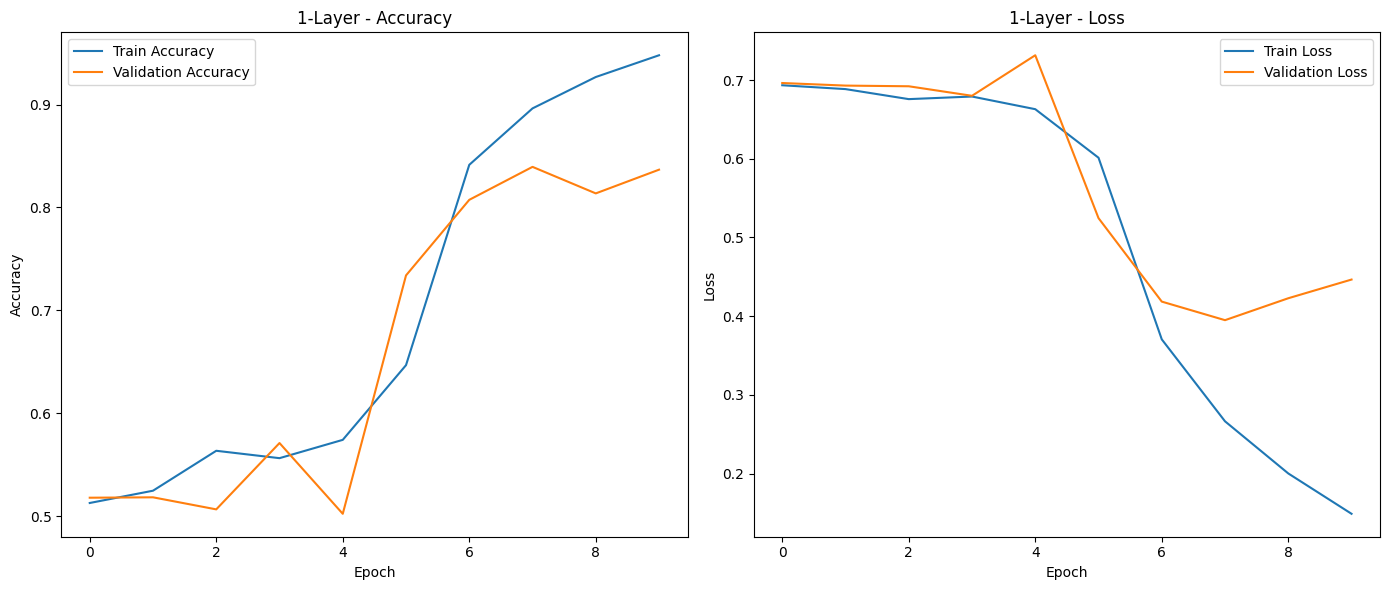

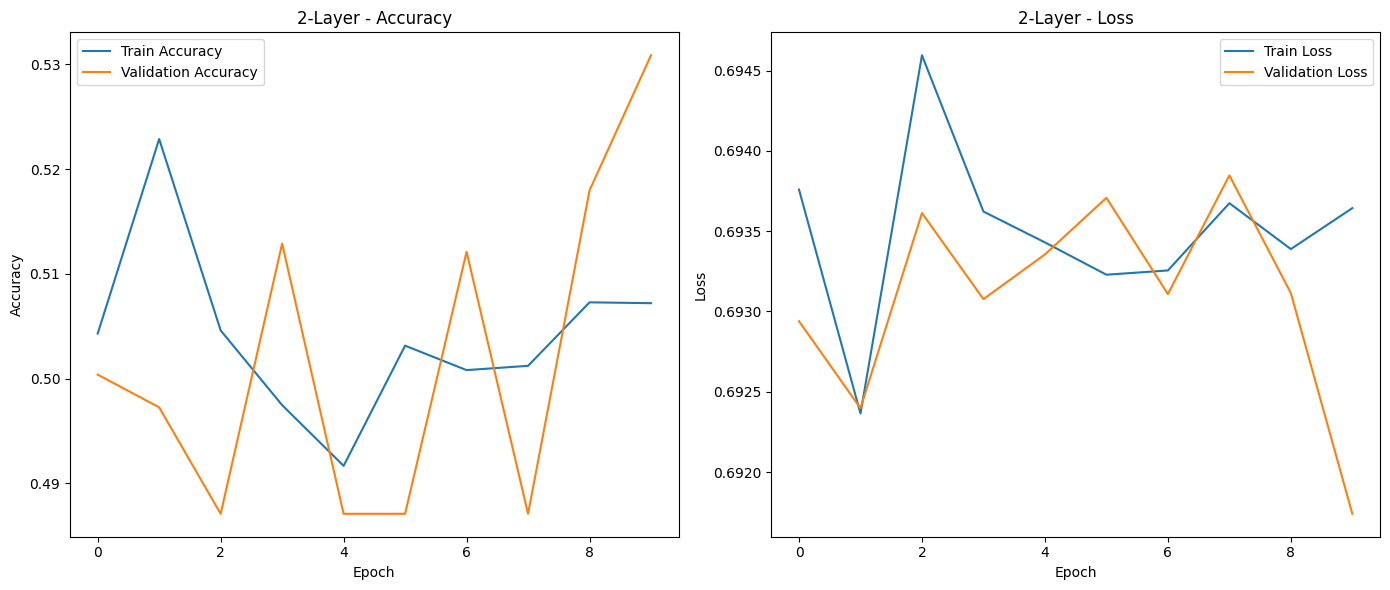

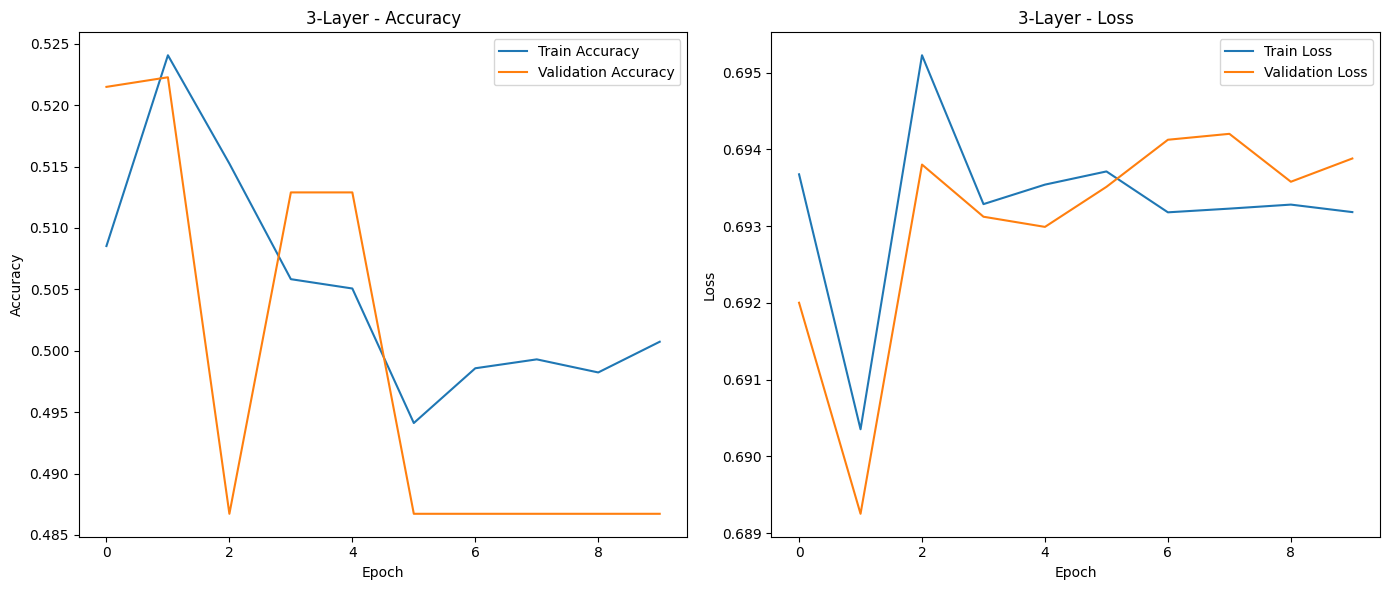

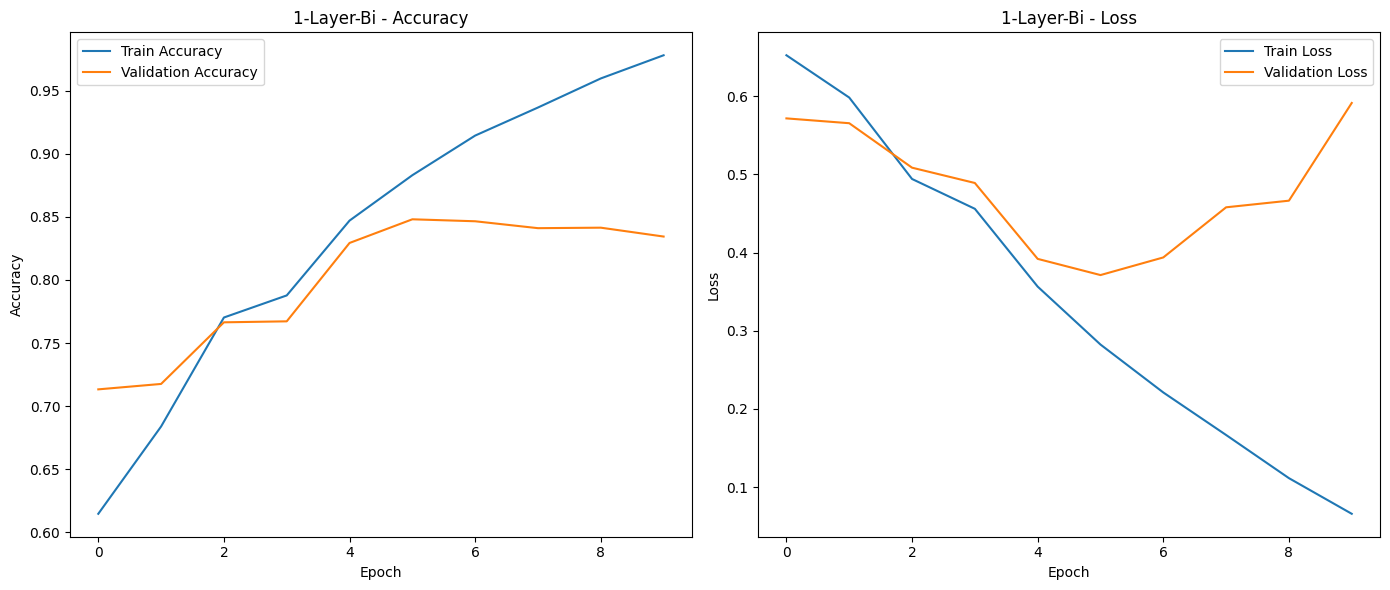

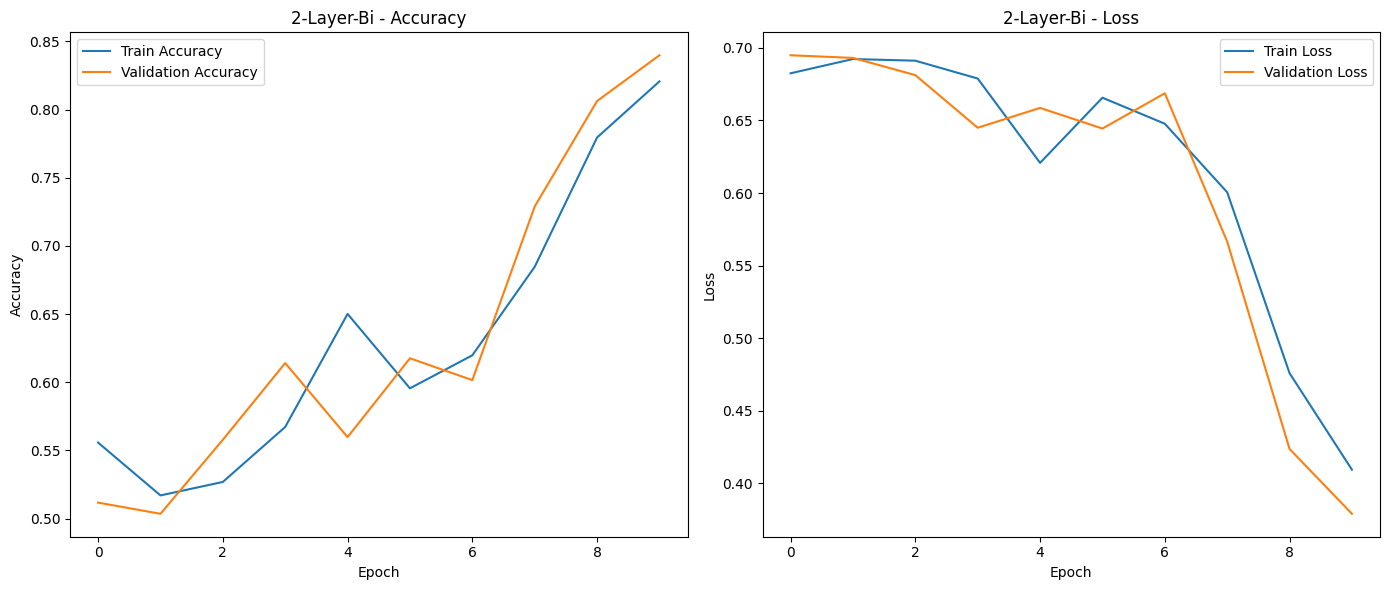

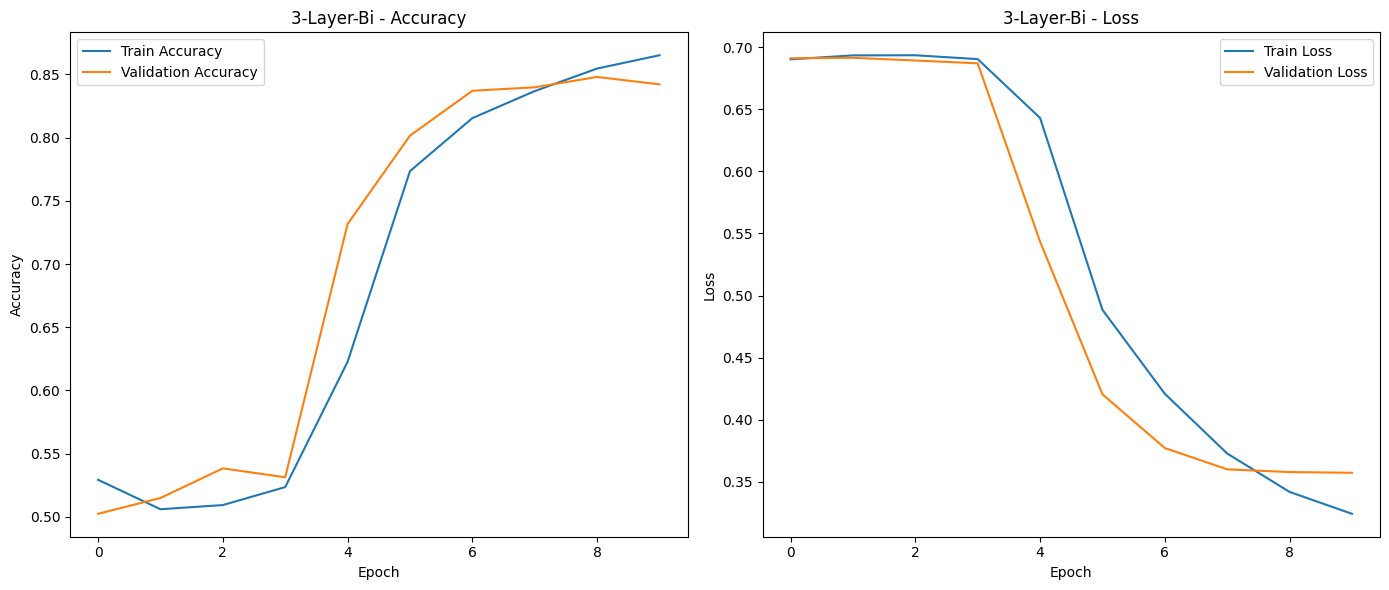

In [16]:

for model_name in history.keys():
    plt.figure(figsize=(14, 6))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history[model_name]['train_acc'],  label='Train Accuracy')
    plt.plot(history[model_name]['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history[model_name]['train_loss'], label='Train Loss')
    plt.plot(history[model_name]['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [18]:
def predict_sentiment(model, text, vocab, max_len=200):
    """Predict sentiment for a single text input"""
    # Preprocess
    tokens = preprocess_text(text)
    # Encode
    encoded = encode_review(tokens, vocab, max_len)
    # Convert to tensor
    tensor = torch.tensor(encoded).unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    # Get prediction
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor).squeeze(1))
    
    # Return probability and sentiment
    probability = prediction.item()
    sentiment = "Positive" if probability >= 0.5 else "Negative"
    
    return probability, sentiment


In [ ]:
# Test on some examples
sample_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
    "It was okay. Nothing special but not terrible either.",
    "Despite some flaws in the plot, the movie had great visual effects and good performances."
]

print("Model predictions on sample reviews:")
model = best_models["3-Layer-Bi"]

for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)


Model predictions on sample reviews:
Review: This movie was absolutely amazing! The acting was ...
Sentiment: Positive (probability: 0.9636)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The ...
Sentiment: Negative (probability: 0.0450)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible eith...
Sentiment: Negative (probability: 0.0447)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had grea...
Sentiment: Positive (probability: 0.8239)
--------------------------------------------------
